# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [39]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [40]:
  # noqa: E402

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [41]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.weights = tf.Variable(tf.random.normal([in_features, out_features]))
        self.bias = tf.Variable(tf.zeros([out_features]))

    def __call__(self, x, activation_fn=None):
        linear = tf.matmul(x, self.weights) + self.bias
        if activation_fn:
            return activation_fn(linear)
        else:
            return linear


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # First layer
        self.hidden_1 = DenseLayer(num_features, n_hidden_1, name="hidden_layer_1")
        # Second layer
        self.hidden_2 = DenseLayer(n_hidden_1, n_hidden_2, name="hidden_layer_2")
        # Output layer
        self.output_layer = DenseLayer(n_hidden_2, num_classes, name="output_layer")

    def __call__(self, x):
        x = self.hidden_1(x, activation_fn=tf.nn.sigmoid)
        x = self.hidden_2(x, activation_fn=tf.nn.sigmoid)
        x = self.output_layer(x, activation_fn=tf.nn.softmax)
        return x

In [42]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [43]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    trainable_variables = nn.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_variables)
    
    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [44]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):

    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step {step}, Loss: {loss}, Accuracy: {acc}")

        # Место для вашего кода

Step 0, Loss: 2601.8740234375, Accuracy: 0.16796875
Step 100, Loss: 401.06097412109375, Accuracy: 0.65234375
Step 200, Loss: 194.63006591796875, Accuracy: 0.75390625
Step 300, Loss: 259.7543029785156, Accuracy: 0.75390625
Step 400, Loss: 168.98129272460938, Accuracy: 0.8125
Step 500, Loss: 187.62872314453125, Accuracy: 0.81640625
Step 600, Loss: 112.44746398925781, Accuracy: 0.87109375
Step 700, Loss: 137.048828125, Accuracy: 0.84375
Step 800, Loss: 121.20059967041016, Accuracy: 0.86328125
Step 900, Loss: 79.90623474121094, Accuracy: 0.8984375
Step 1000, Loss: 123.01167297363281, Accuracy: 0.8671875
Step 1100, Loss: 80.74559020996094, Accuracy: 0.8984375
Step 1200, Loss: 97.3873291015625, Accuracy: 0.8984375
Step 1300, Loss: 103.7930679321289, Accuracy: 0.8828125
Step 1400, Loss: 88.06256103515625, Accuracy: 0.88671875
Step 1500, Loss: 82.0029525756836, Accuracy: 0.8984375
Step 1600, Loss: 62.500732421875, Accuracy: 0.9375
Step 1700, Loss: 78.53605651855469, Accuracy: 0.91015625
Step 1

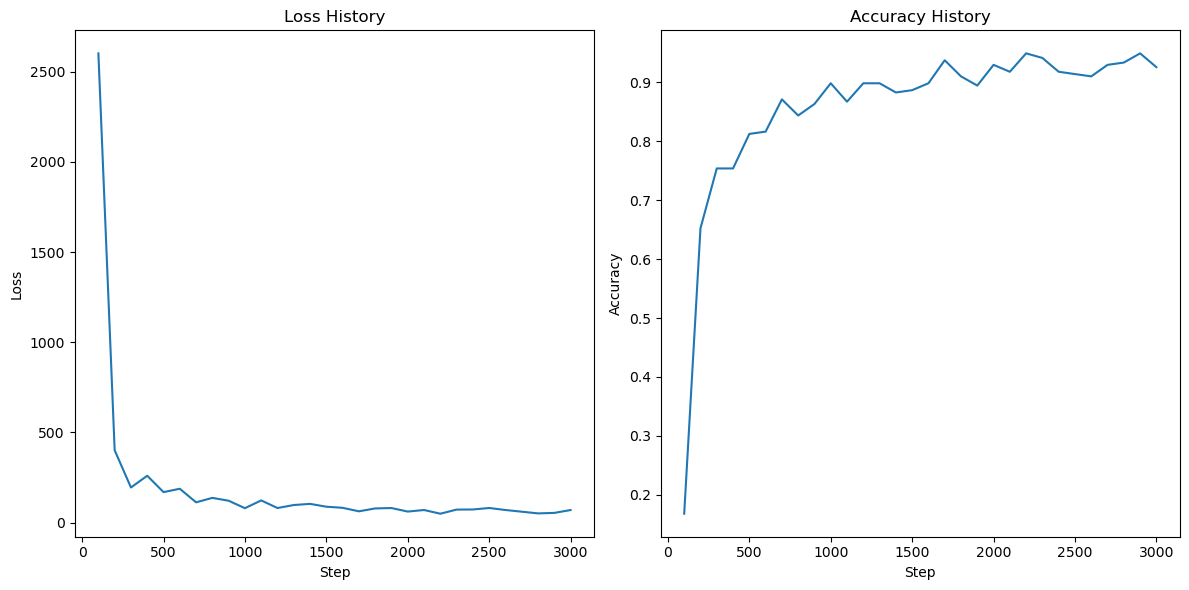

In [46]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(display_step, training_steps+1, display_step), loss_history)
plt.title('Loss History')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(display_step, training_steps+1, display_step), accuracy_history)
plt.title('Accuracy History')
plt.xlabel('Step')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [47]:
# Вычислите точность обученной нейросети

y_pred_test=neural_net(x_test)
print(f'Accuracy of the neural network on test data: {accuracy(y_pred=y_pred_test, y_true=y_test)*100:.2f}%')

Accuracy of the neural network on test data: 90.18%


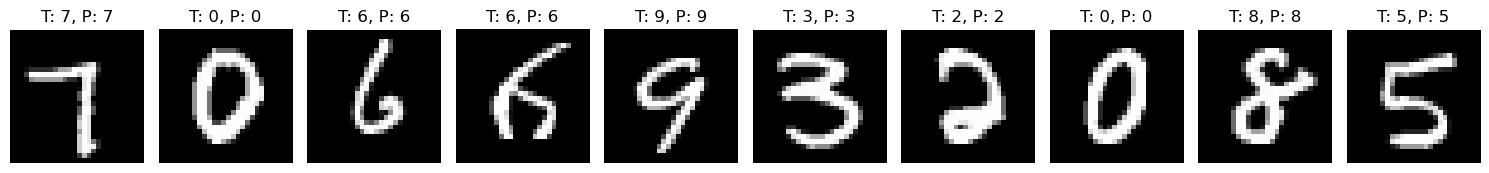

In [49]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

import random

# Выбираем случайные 10 индексов из тестовой выборки
random_indices = random.sample(range(len(x_test)), 10)

plt.figure(figsize=(15, 3))

for i, idx in enumerate(random_indices, 1):
    test_image = x_test[idx:idx+1]
    true_label = y_test[idx]
    
    pred = neural_net(test_image)
    predicted_label = tf.argmax(pred, axis=1).numpy()[0]
    
    plt.subplot(1, 10, i)
    plt.imshow(test_image.reshape(28, 28), cmap='gray')
    plt.title(f"T: {true_label}, P: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


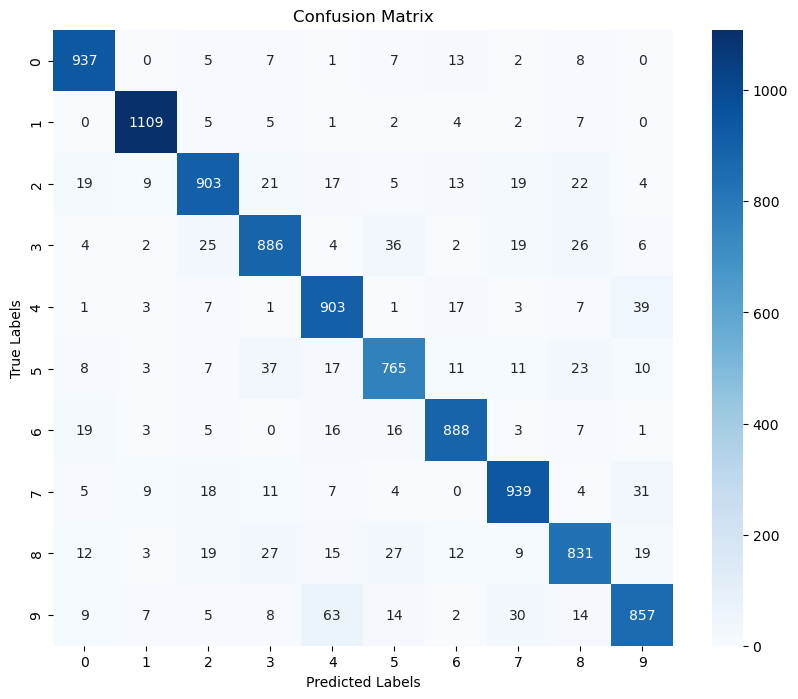

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = neural_net(x_test)
predicted_labels = tf.argmax(y_pred, axis=1).numpy()

conf_matrix = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Найбільша точність розпізнавання це цифра 1 а найменша це 5